# **Flowers 102**

## **Data Loading**

In [1]:
import matplotlib.pyplot as plt

# Define a function for plotting images
def plot(x,title=None):

    # Move tensor to CPU and convert to numpy
    x_np = x.cpu().numpy()

    # If tensor is in (C, H, W) format, transpose to (H, W, C)
    if x_np.shape[0] == 3 or x_np.shape[0] == 1:
        x_np = x_np.transpose(1, 2, 0)

    # If grayscale, squeeze the color channel
    if x_np.shape[2] == 1:
        x_np = x_np.squeeze(2)

    x_np = x_np.clip(0, 1)

    # Create a matplotlib figure and axis for plotting
    fig, ax = plt.subplots()
    if len(x_np.shape) == 2:  # Grayscale
        im = ax.imshow(x_np, cmap='gray')
    else:
        im = ax.imshow(x_np)
    plt.title(title)
    ax.axis('off')
    fig.set_size_inches(10, 10)
    plt.show()

In [ ]:
# Downloading and extracting the dataset
# Uncomment the following lines if you are running this in a Jupyter Notebook
!wget https://gist.githubusercontent.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1/raw/403325f5110cb0f3099734c5edb9f457539c77e9/Oxford-102_Flower_dataset_labels.txt
!wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip 'flower_data.zip'

In [3]:
import torch
from torchvision import datasets, transforms
import os
import pandas as pd

# Directory and transforms
data_dir = '/content/flower_data/'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define data transformations
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transform)
dataset_labels = pd.read_csv('Oxford-102_Flower_dataset_labels.txt', header=None)[0].str.replace("'", "").str.strip()

# Load the dataset into a DataLoader for batching
dataloader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)

In [4]:
# Extract the batch of images and labels
images, labels = next(iter(dataloader))

print(f"Images tensor shape: {images.shape}")
print(f"Labels tensor shape: {labels.shape}")


Images tensor shape: torch.Size([6552, 3, 224, 224])
Labels tensor shape: torch.Size([6552])


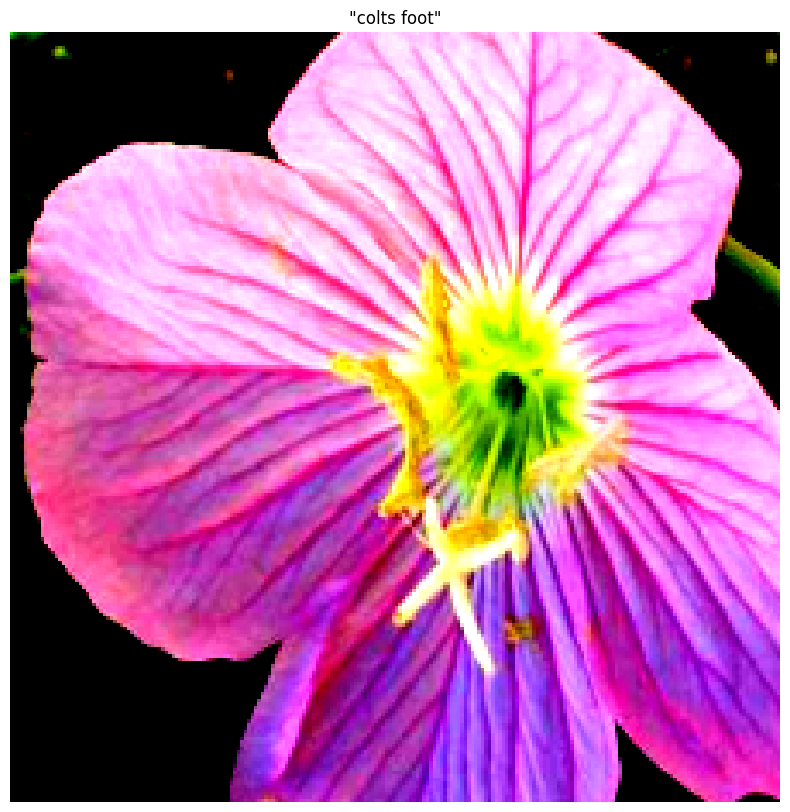

In [5]:
i = 11
# Plot the 11th image from the dataset with its label
plot(images[i],dataset_labels[i]);

## **Pretrained Alexnet**

In [6]:
import torch
from torchvision import models, transforms
import requests
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#define alexnet model
alexnet = models.alexnet(pretrained=True).to(device)
labels = {int(key):value for (key, value) in requests.get('https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json').json().items()}

#transform image for use in model
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 141MB/s]


In [7]:
img = images[i]

In [8]:
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()
img = to_pil(img)

In [9]:
img_t = preprocess(img).unsqueeze_(0).to(device)

In [10]:
# Print the shape of the preprocessed image tensor
img_t.shape

torch.Size([1, 3, 224, 224])

In [11]:
#classify the image with alexnet
scores, class_idx = alexnet(img_t).max(1)
print('Predicted class:', labels[class_idx.item()])

Predicted class: umbrella


## **Finetuning**

In [12]:
# Extract the weights of various layers in AlexNet
w0 = alexnet.features[0].weight.data
w1 = alexnet.features[3].weight.data
w2 = alexnet.features[6].weight.data
w3 = alexnet.features[8].weight.data
w4 = alexnet.features[10].weight.data
w5 = alexnet.classifier[1].weight.data
w6 = alexnet.classifier[4].weight.data
w7 = alexnet.classifier[6].weight.data

In [13]:
# Save and Load
# w = [w0,w1,w2,w3,w4,w5,w6,w7]
# torch.save(w, 'Hahn_Alex.pt')
# w = torch.load('Hahn_Alex.pt')
# [w0,w1,w2,w3,w4,w5,w6,w7] = w
# [w0,w1,w2,w3,w4,w5,w6,w7] = torch.load('Hahn_Alex.pt')

In [14]:
# Print the shapes of the image tensor and w0
img_t.shape,w0.shape

(torch.Size([1, 3, 224, 224]), torch.Size([64, 3, 11, 11]))

In [15]:
img_t.shape

torch.Size([1, 3, 224, 224])

In [16]:
img_t[0,:,:,:].shape

torch.Size([3, 224, 224])

In [17]:
# Define a function to scale an image tensor
def scale(img):
    # Normalize the NumPy array to the range [0, 1]
    max_value = img.max()
    min_value = img.min()
    normalized_array = (img - min_value) / (max_value - min_value)
    return normalized_array

In [18]:
# Define a function to plot an image tensor
def tensor_plot(img_t,index=0):
    numpy_array = img_t[index,:,:,:].cpu().numpy()
    numpy_array_transposed = numpy_array.transpose(1, 2, 0)
    numpy_array_transposed = scale(numpy_array_transposed)
    plt.imshow(numpy_array_transposed)
    plt.show()

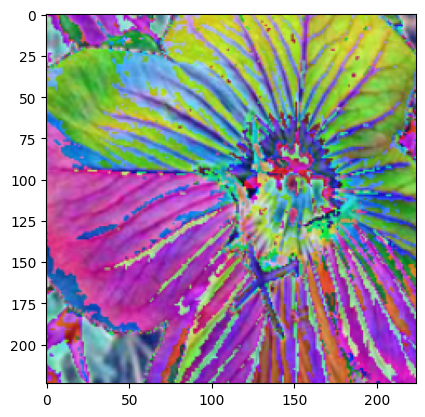

In [19]:
# Plot the image tensor
tensor_plot(img_t)

In [20]:
w0.shape

torch.Size([64, 3, 11, 11])

In [21]:
f0 = F.conv2d(img_t, w0, stride=4, padding=2)

In [22]:
f0.shape

torch.Size([1, 64, 55, 55])

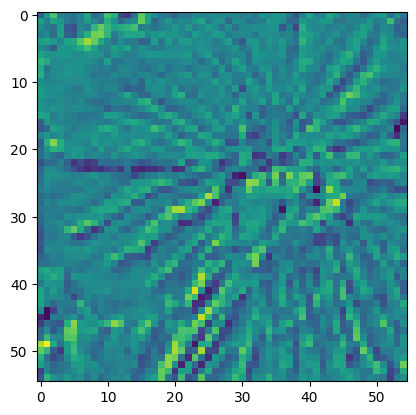

In [23]:
i = 0
plt.imshow(f0[0,i,:,:].cpu().numpy())

In [24]:
# for i in range(64):
#     tensor_plot(w0,i)
#     plt.imshow(f0[0,i,:,:].cpu().numpy())
#     plt.show()

In [25]:
import torch
import matplotlib.pyplot as plt

# Define a function to plot feature maps with filters
def plot_feature_maps_with_filters(feature_maps, filters):
    # Remove batch dimension if it exists
    if feature_maps.dim() == 4:
        feature_maps = feature_maps.squeeze(0)

    # Normalize feature maps to [0, 1]
    feature_maps = (feature_maps - feature_maps.min()) / (feature_maps.max() - feature_maps.min())

    def add_filter_to_feature_map(filter_tensor, feature_map_tensor):
        # Ensure the feature map is 2D [H, W]
        if feature_map_tensor.dim() > 2:
            feature_map_tensor = feature_map_tensor.squeeze(0)

        # Convert grayscale feature map to RGB by repeating the single channel 3 times
        feature_map_rgb = feature_map_tensor.unsqueeze(0).repeat((3, 1, 1))

        # Normalize the filter to [0, 1]
        filter_tensor = (filter_tensor - filter_tensor.min()) / (filter_tensor.max() - filter_tensor.min())

        # Ensure the filter fits into the feature map
        min_dim = min(feature_map_tensor.shape)
        filter_size = min(filter_tensor.shape[-1], min_dim)

        # Crop the filter if needed
        filter_cropped = filter_tensor[:, :filter_size, :filter_size]

        # Overlay the RGB filter at the lower-left corner of the feature map
        feature_map_rgb[:, -filter_size:, :filter_size] = filter_cropped

        # Clip the values to be in the range [0, 1]
        feature_map_rgb = torch.clamp(feature_map_rgb, 0, 1)

        return feature_map_rgb

    # Plot montage of feature maps
    fig, axes = plt.subplots(8, 8, figsize=(15, 15))

    for ax, feature_map, filter_ in zip(axes.flat, feature_maps, filters):
        # Add RGB filter to grayscale feature map
        modified_feature_map = add_filter_to_feature_map(filter_, feature_map)

        # Plot modified feature map
        ax.imshow(modified_feature_map.permute(1, 2, 0).cpu().numpy(), interpolation='none')  # Added 'none' interpolation
        ax.axis('off')

    plt.show()



In [26]:
f0.shape,w0.shape

(torch.Size([1, 64, 55, 55]), torch.Size([64, 3, 11, 11]))

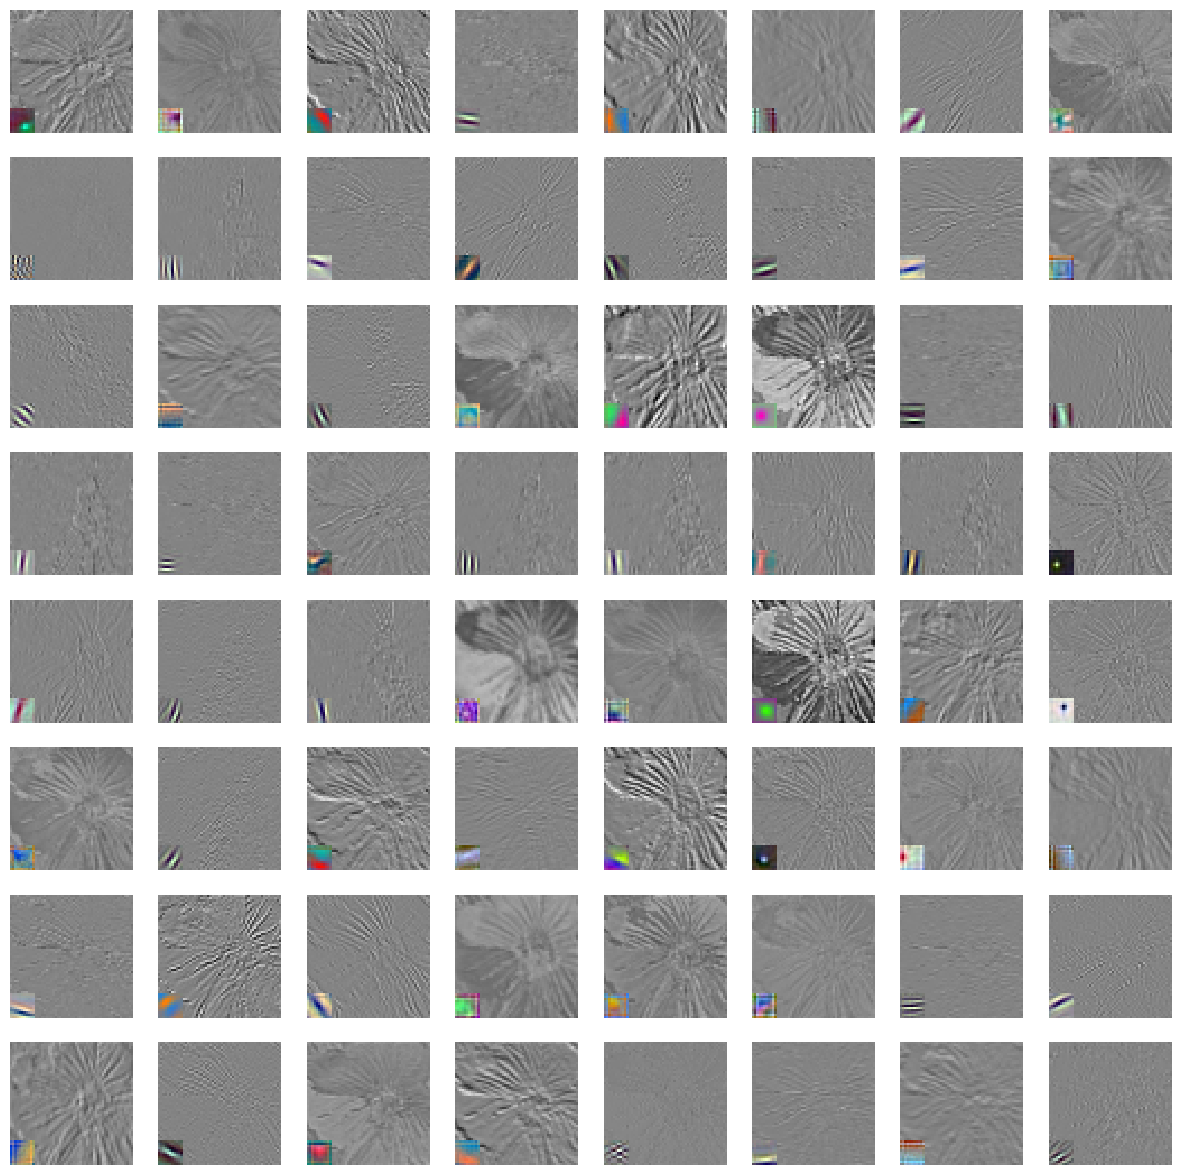

In [27]:
plot_feature_maps_with_filters(f0, w0)